<a href="https://colab.research.google.com/github/StillWork/AIDD-2208-add/blob/main/c_85_10_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  GAN을 이용한 MNIST 이미지 생성

- GAN 개념 

 <img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-20%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2011.42.33.png?raw=1" width="600" align="left">. 




- Wasserstein GAN 사용
- 참고 [GAN 개념 소개](https://towardsdatascience.com/fundamentals-of-generative-adversarial-networks-b7ca8c34f0bc)
- [DeepChem](https://deepchem.readthedocs.io/en/latest/index.html)이 제공하는 WGAN 클래스를 사용하겠다


In [6]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 22.0 MB/s 
     |████████████████████████████████| 29.5 MB 1.2 MB/s 


# Import

In [18]:
import numpy as np
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## MNIST 이미지 데이터

In [8]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

11490434/11490434 [==============================] - 2s 0us/step


In [9]:
mnist[0][0].shape

(60000, 28, 28)

In [10]:
images = mnist[0][0].reshape((-1, 28, 28, 1))/255
dataset = dc.data.NumpyDataset(images)
dataset

<NumpyDataset X.shape: (60000, 28, 28, 1), y.shape: (60000, 1), w.shape: (60000, 1), task_names: [0]>

- 샘플 이미지 보기 (16개의 이미지만 그린다)


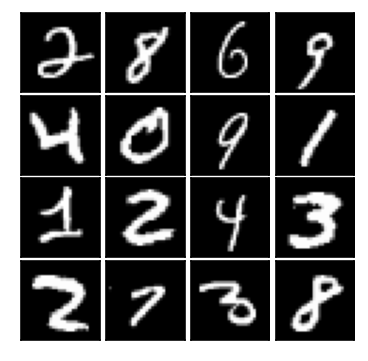

In [15]:
def plot_digits(im):
  plt.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plt.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images[16:32])

# GAN 구현

- GAN은 다음과 같이 두개의 코드로 구성된다

- 생성자
 - 랜덤 신호를 입력으로 받고, 훈련 데이터에 있는 MNIST와 같은 이미지를 닮은 출력을 생성한다
- 판별자 
 - 생성자가 만든 (가짜) 출력 이미지와 (실제) 훈련 이미지를 입력으로 받아 가짜 이미지와 실제 이미지를 구분하는 작업을 수행한다

- Wasserstein GAN (WGAN)을 사용하겠다
- 생성자는 우선 Dense망을 사용하여 입력 잡음을 7x7 크기의 이미지로 바꾸며 8개이 채널을 사용한다
 - 두 번의 컨볼류션 계층을 수행하며 각각 업샘플링을 하여 14x14 그리고 28x28 크기의 이미지로 변형한다
 
- 판별자는 위의 작업의 역순의 작업을 수행한다
 - 두 번의 컨볼류션 계층을 수행하며 각각 1/2 다운 샘플링을 하여 14x14 그리고 7x7 크기의 피처맵을 만든다
 - 이후 전결합망(dense)을 통과하여 단일값을 갖는 출력을 생성한다
 - WGAN에서는 softplus 활성함수를 사용하여 (0~1) 사이의 값이 아닌, 임의의 길이를 갖는 값을 출력하며 이를 확률이 아니라 거리(distance)로 사용한다
 - WGAN에서는 실제 이미지일 확률을 구하는 것이 아니라, 거리를 구하는데 이 거리의 의미는 훈련 이미지의 분포와 생성 이미지의 분포 사이의 "거리"를 나타낸다
 - 이 거리 값은 생성자를 훈련시키는데 사용된다

## GAN 클래스 정의

In [31]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), model_dir = 'gan')

# 모델 학습

- 이미지 생성자는 dataset에서 데이터를 가지고 오며 epoch는 100으로 설정했다

- 일반적인 GAN을 구현할 때는 생성자와 판별자를 훈련시키는데 서로 너무 큰 실력 차이가 나지 않도록 세심하게 주의를 해야 한다
- 실력(성능)의 차이가 너무 크면 균형있게 두개의 모델을 학습을 진행하기가 어렵기 때문이다.

- WGAN에서는 이러한 문제가 생기지 않는데, 왜냐하면 판별자의 성능이 좋아지면 더 명확한 결과를 알려줄 수 있고 이를 통해 생성자가 학습을 더 잘 할 수 있게 된다
- `generator_steps=0.2`로 설정하였다. 이는 판별자가 5회 학습하면 생성자가 1회 학습하는 비율인데, 이렇게 하여 학습 속도를 높이고 더 나은 성능을 얻도록 한다

## softmax와 softplus

(-0.1, 3.0)

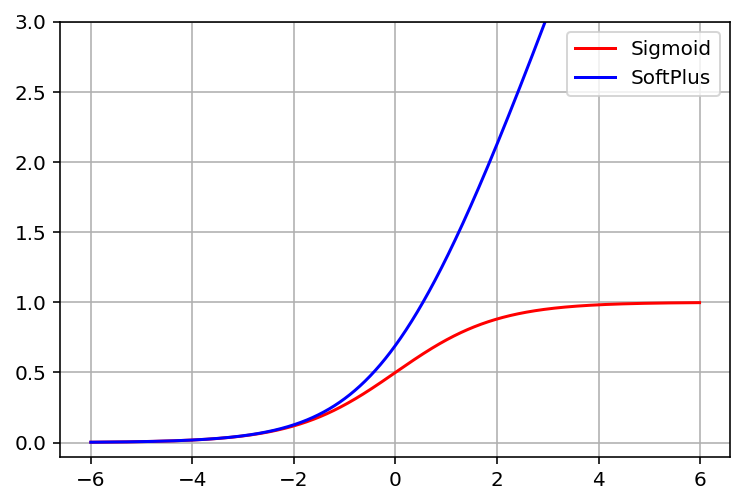

In [19]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

x = np.arange(-6, 6, 0.01)

def sigmoid(x): # 시그모이드(Sigmoid, S-커브), Logistic Regression
    return 1 / (1 + np.exp(-x)) 
ax.plot(x, sigmoid(x), color='r', linestyle='-', label="Sigmoid")

def softplus_func(x): # SoftPlus 함수
    return np.log( 1 + np.exp(x) )
ax.plot(x, softplus_func(x), color='b', linestyle='-', label="SoftPlus")

ax.grid()
ax.legend()
plt.ylim(-0.1, 3)

## dataset에서 데이터를 배치단위로 읽는다
- iterbatches() 함수 사용

In [32]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 4999: generator average loss 0.541579, discriminator average loss -0.0333952
Ending global_step 9999: generator average loss 0.604751, discriminator average loss -0.00792508
Ending global_step 14999: generator average loss 0.593689, discriminator average loss -0.00704562
Ending global_step 19999: generator average loss 0.580028, discriminator average loss -0.00723264
Ending global_step 24999: generator average loss 0.58415, discriminator average loss -0.00771628
Ending global_step 29999: generator average loss 0.594199, discriminator average loss -0.00766256
Ending global_step 34999: generator average loss 0.586687, discriminator average loss -0.00670649
Ending global_step 39999: generator average loss 0.580139, discriminator average loss -0.00579391
Ending global_step 44999: generator average loss 0.572149, discriminator average loss -0.00585591
Ending global_step 49999: generator average loss 0.557887, discriminator average loss -0.00567386
Ending global_step 54999

## 이미지 생성 결과 보기

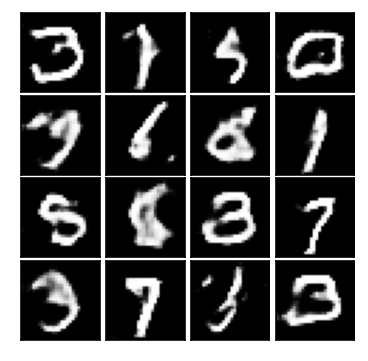

In [33]:
plot_digits(gan.predict_gan_generator(batch_size=100))

# 백업된 모델 사용하기

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), 
               model_dir = '/content/drive/MyDrive/gan')
gan.restore()

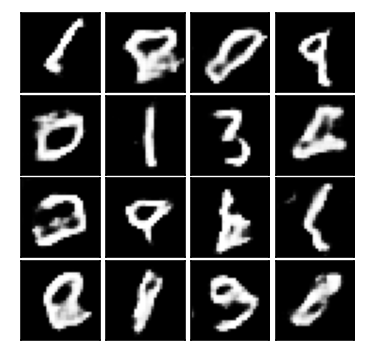

In [38]:
plot_digits(gan.predict_gan_generator(batch_size=16))

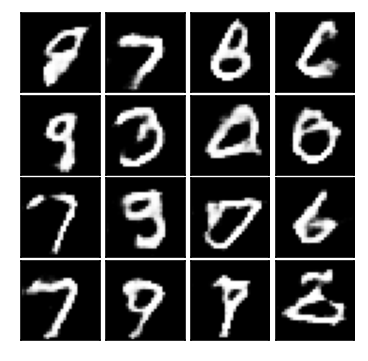

In [42]:
plot_digits(gan.predict_gan_generator(batch_size=16))